# Yale Data SST HDDM

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hddm
import warnings
warnings.filterwarnings('ignore')

## Prepare Data

In [3]:
data = hddm.load_csv('yale_data_for_hddm.csv',header=None)
data.columns = ['subj_idx','rt','condition','p_stop','p_error','session']

data['rt'] = data['rt']/1000
response = []
condition = []

for i in range(len(data.index)):
    cond = int(data[data.index == i].condition)
    if cond == 1: #correct go
        response.append(1)
        condition.append('Go')
    elif cond == 2: #incorrect go (0 RT)
        response.append(0)
        data.rt[i] = 999
        condition.append('Go')
    elif cond == 3: #correct stop (0 RT)
        response.append(1)
        condition.append('Stop')
        data.rt[i] = 999
    else: #incorrect stop
        response.append(0)
        condition.append('Stop')
        
data['response'] = response
data['condition'] = condition

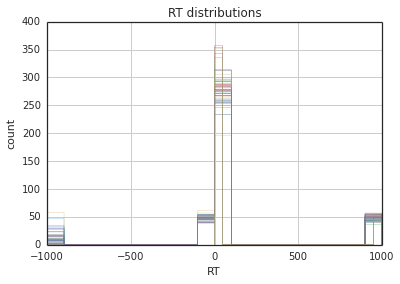

In [14]:
sns.set_style('white')
data = hddm.utils.flip_errors(data) #error RTs are flipped to be negative
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20,histtype='step', ax=ax)

## Simplest Model: No Variation By Condition

In [15]:
m = hddm.HDDM(data)
m.find_starting_values()
m.sample(1000, burn=100)

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/optimize/optimize.py:1753: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/optimize/optimize.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


 [-----------------100%-----------------] 1001 of 1000 complete in 2254.5 sec

Plotting a
Plotting v
Plotting t


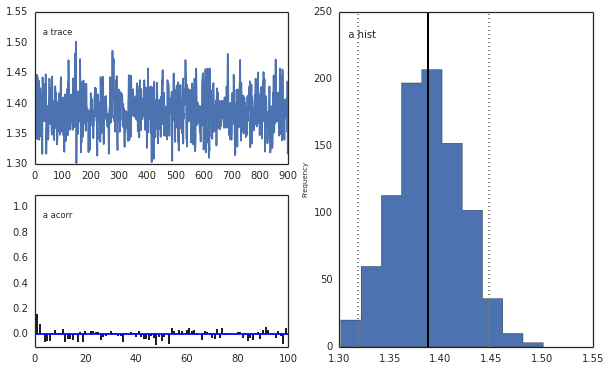

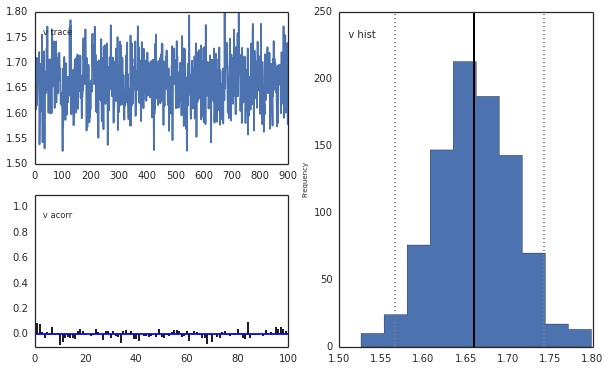

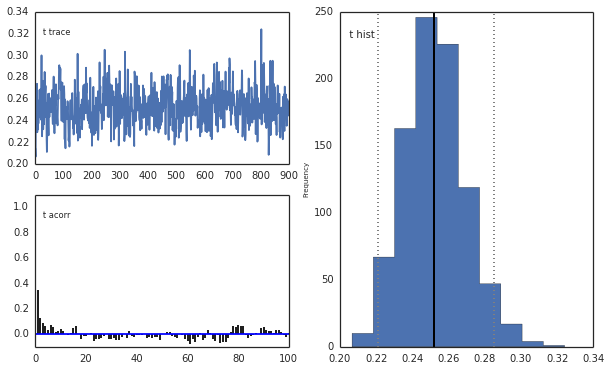

In [16]:
m.plot_posteriors(['v','a','t'])

In [56]:
m_stats = m.gen_stats()
m_stats[m_stats.index.isin(['v','v_std','a','a_std','t','t_std'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.38796,0.0332387,1.32306,1.36629,1.3872,1.40978,1.45568,0.00119387
a_std,0.24866,0.0245328,0.205939,0.230877,0.245853,0.264133,0.302638,0.00102209
v,1.66127,0.0464285,1.57463,1.62963,1.65929,1.69313,1.75455,0.00166981
v_std,0.331551,0.0363738,0.269327,0.305662,0.328298,0.357339,0.405071,0.00146167
t,0.252766,0.0168239,0.222403,0.240968,0.251931,0.263772,0.288779,0.00082312
t_std,0.127548,0.0157909,0.0999101,0.11639,0.125939,0.137661,0.16303,0.000860834


(-0.36843290163635367, 0.0044318400873839849)

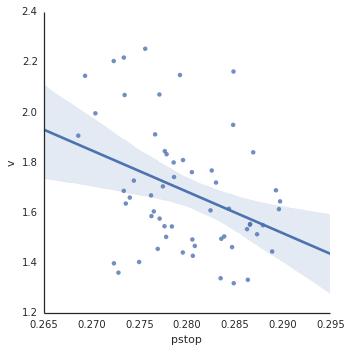

In [72]:
subjects = data.subj_idx.unique()

corr_df = {'pstop':[],'v':[],'a':[],'t':[]}
for sub in subjects:
    mean_pstop = data[data.subj_idx == sub].p_stop.mean()
    mean_v = float(m_stats[m_stats.index == 'v_subj.%s'%(sub)]['mean'])
    mean_a = float(m_stats[m_stats.index == 'a_subj.%s'%(sub)]['mean'])
    mean_t = float(m_stats[m_stats.index == 't_subj.%s'%(sub)]['mean'])
    if mean_v > 1.0: #removing 1 obvious outlier
        corr_df['pstop'].append(mean_pstop)
        corr_df['v'].append(mean_v)
        corr_df['a'].append(mean_a)
        corr_df['t'].append(mean_t)
    else:
        print("subject %s removed as outlier"%(sub))
corr_df = pd.DataFrame.from_dict(corr_df)
sns.lmplot(x='pstop',y='v',data=corr_df)
from scipy.stats import pearsonr
pearsonr(corr_df['pstop'],corr_df['v'])


##### We find a negative correlation between drift rate and p(stop).
##### No correlation with other parameters.


## More Complex Model: Vary all parameters by condition

In [19]:
m_cond = hddm.HDDM(data, depends_on={'v': 'condition',
                                     'a': 'condition',
                                     't': 'condition'})
m_cond.find_starting_values()
m_cond.sample(10000, burn=1000)

 [-----------------100%-----------------] 10001 of 10000 complete in 72294.3 sec

Plotting a(Go)
Plotting a(Stop)
Plotting v(Go)
Plotting v(Stop)
Plotting t(Go)
Plotting t(Stop)


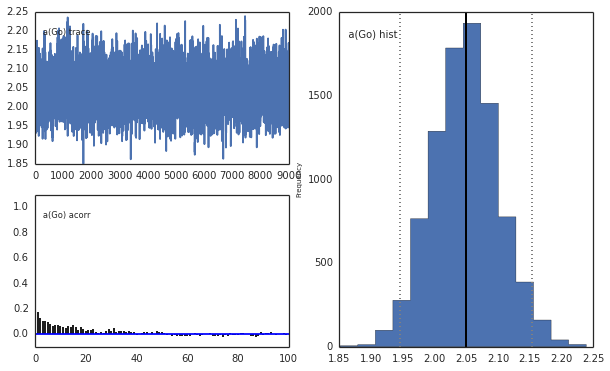

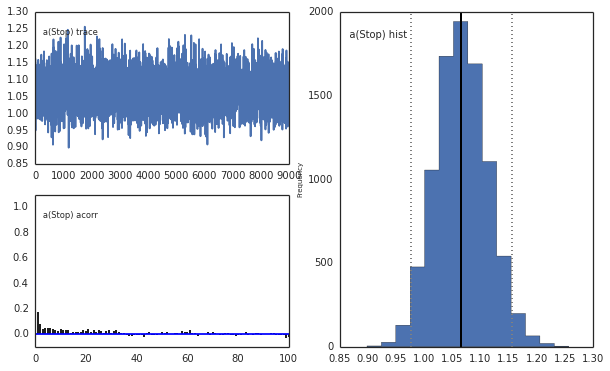

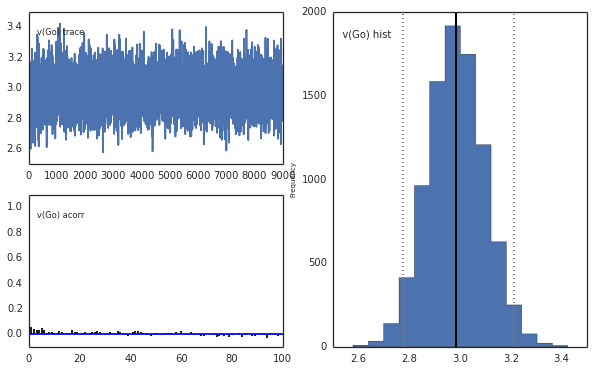

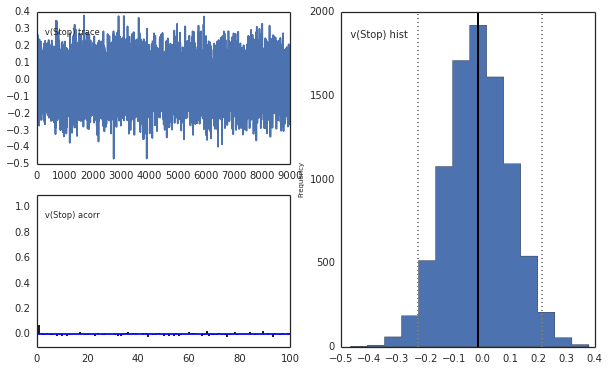

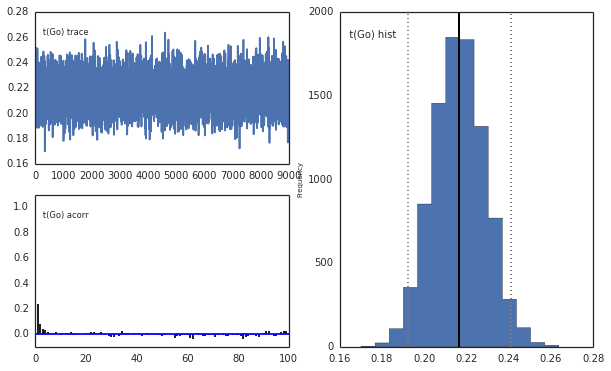

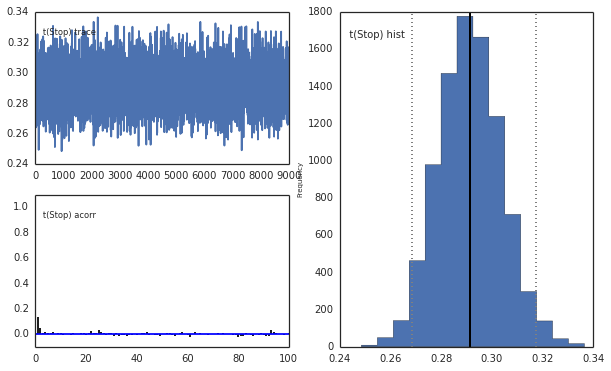

In [20]:
m_cond.plot_posteriors(['v','a','t'])

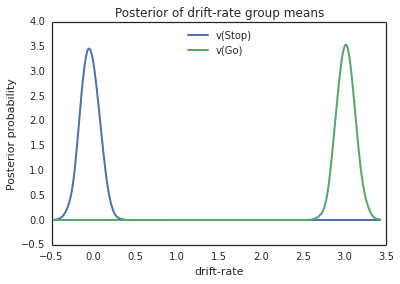

In [22]:
v_stop, v_go, = m_cond.nodes_db.node[['v(Stop)', 'v(Go)']]
hddm.analyze.plot_posterior_nodes([v_stop, v_go])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')

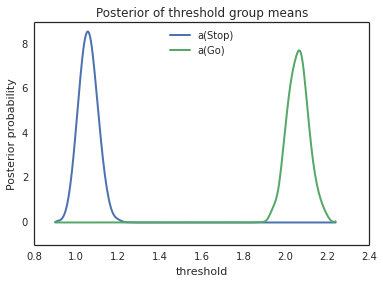

In [24]:
a_stop, a_go, = m_cond.nodes_db.node[['a(Stop)', 'a(Go)']]
hddm.analyze.plot_posterior_nodes([a_stop, a_go])
plt.xlabel('threshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

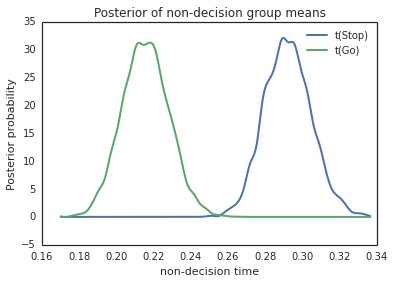

In [25]:
t_stop, t_go, = m_cond.nodes_db.node[['t(Stop)', 't(Go)']]
hddm.analyze.plot_posterior_nodes([t_stop, t_go])
plt.xlabel('non-decision time')
plt.ylabel('Posterior probability')
plt.title('Posterior of non-decision group means')

In [26]:
print "v P(Go > Stop) = ", (v_go.trace() > v_stop.trace()).mean()
print "a P(Go > Stop) = ", (a_go.trace() > a_stop.trace()).mean()
print "t P(Go > Stop) = ", (t_go.trace() > t_stop.trace()).mean()

v P(Go > Stop) =  1.0
a P(Go > Stop) =  1.0
t P(Go > Stop) =  0.000111111111111


(-0.13779778638358606, 0.29798075960158665)
(0.13145276215600968, 0.32099323541881042)


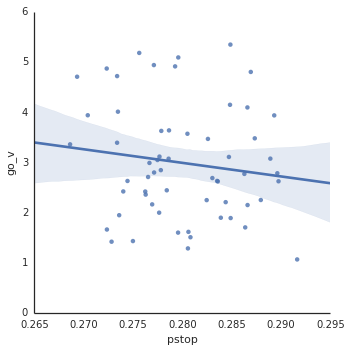

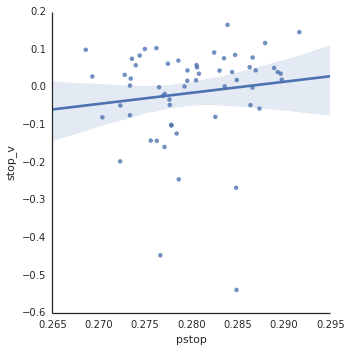

In [80]:
m_cond_stats = m_cond.gen_stats()

subjects = data.subj_idx.unique()

corr_df = {'pstop':[],'go_v':[],'go_a':[],'go_t':[],'stop_v':[],'stop_a':[],'stop_t':[]}
for sub in subjects:
    mean_pstop = data[data.subj_idx == sub].p_stop.mean()
    go_v = float(m_cond_stats[m_cond_stats.index == 'v_subj(Go).%s'%(sub)]['mean'])
    go_a = float(m_cond_stats[m_cond_stats.index == 'a_subj(Go).%s'%(sub)]['mean'])
    go_t = float(m_cond_stats[m_cond_stats.index == 't_subj(Go).%s'%(sub)]['mean'])
    stop_v = float(m_cond_stats[m_cond_stats.index == 'v_subj(Stop).%s'%(sub)]['mean'])
    stop_a = float(m_cond_stats[m_cond_stats.index == 'a_subj(Stop).%s'%(sub)]['mean'])
    stop_t = float(m_cond_stats[m_cond_stats.index == 't_subj(Stop).%s'%(sub)]['mean'])
    corr_df['pstop'].append(mean_pstop)
    corr_df['go_v'].append(go_v)
    corr_df['go_a'].append(go_a)
    corr_df['go_t'].append(go_t)
    corr_df['stop_v'].append(stop_v)
    corr_df['stop_a'].append(stop_a)
    corr_df['stop_t'].append(stop_t)
        
corr_df = pd.DataFrame.from_dict(corr_df)
from scipy.stats import pearsonr
print(pearsonr(corr_df['pstop'],corr_df['go_v']))
print(pearsonr(corr_df['pstop'],corr_df['stop_v']))
sns.lmplot(x='pstop',y='go_v',data=corr_df)
sns.lmplot(x='pstop',y='stop_v',data=corr_df)


##### There are no correlations between parameters and p(stop) in this model

## Vary only drift rate by condition

In [4]:
m_drift = hddm.HDDM(data, depends_on={'v': 'condition'})
m_drift.find_starting_values()
m_drift.sample(5000, burn=200)

 [-----------------70%------            ] 3510 of 5000 complete in 19256.3 secHalting at iteration  3509  of  5000


Plotting a
Plotting v(Go)
Plotting v(Stop)
Plotting t


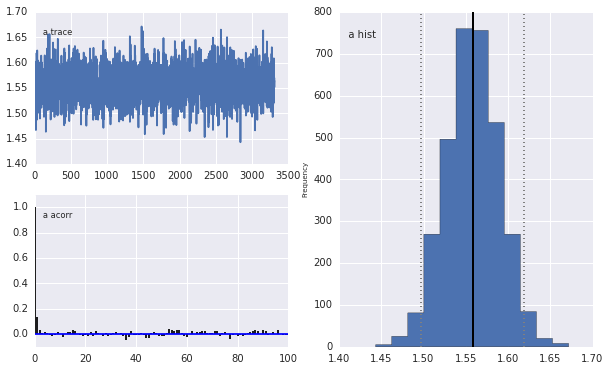

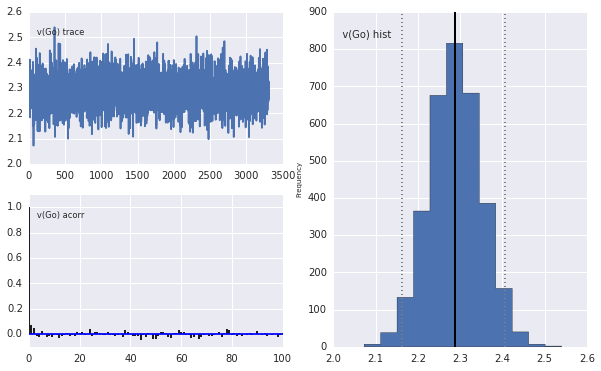

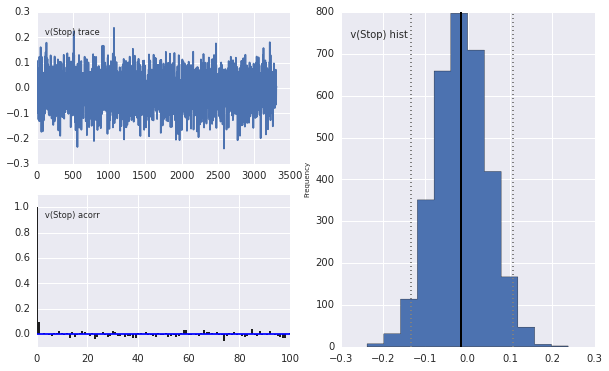

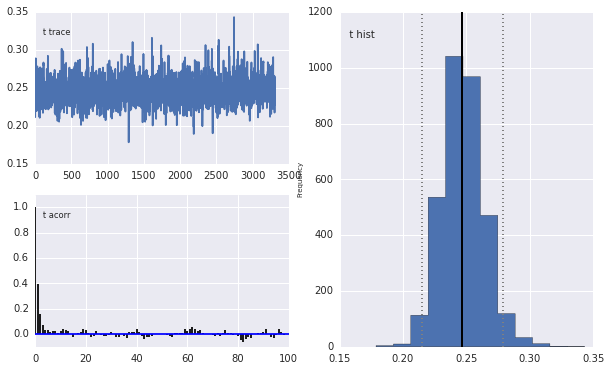

In [5]:
m_drift.plot_posteriors(['v','a','t'])

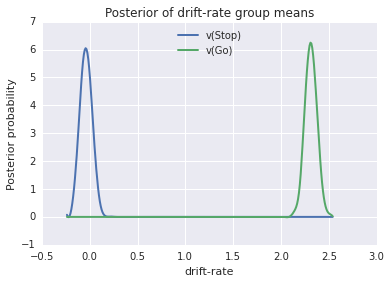

In [6]:
v_stop, v_go, = m_drift.nodes_db.node[['v(Stop)', 'v(Go)']]
hddm.analyze.plot_posterior_nodes([v_stop, v_go])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')

(-0.20490319175180652, 0.11952154776152922)
(0.12366358869284182, 0.35074625603347864)


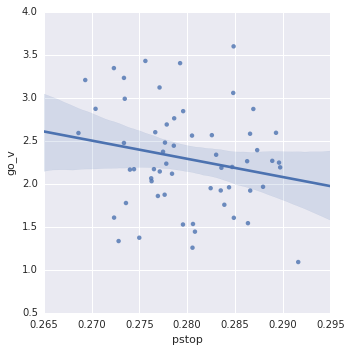

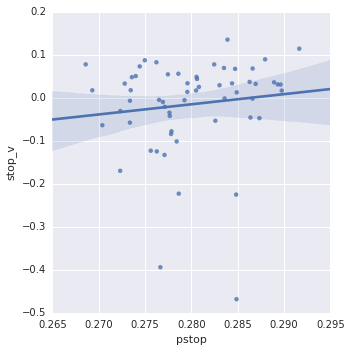

In [10]:
m_drift_stats = m_drift.gen_stats()

subjects = data.subj_idx.unique()

corr_df = {'pstop':[],'go_v':[],'stop_v':[]}
for sub in subjects:
    mean_pstop = data[data.subj_idx == sub].p_stop.mean()
    go_v = float(m_drift_stats[m_drift_stats.index == 'v_subj(Go).%s'%(sub)]['mean'])
    stop_v = float(m_drift_stats[m_drift_stats.index == 'v_subj(Stop).%s'%(sub)]['mean'])
    #if mean_v > 1.0: #removing obvious outlier
    corr_df['pstop'].append(mean_pstop)
    corr_df['go_v'].append(go_v)
    corr_df['stop_v'].append(stop_v)
        
corr_df = pd.DataFrame.from_dict(corr_df)
from scipy.stats import pearsonr
print(pearsonr(corr_df['pstop'],corr_df['go_v']))
print(pearsonr(corr_df['pstop'],corr_df['stop_v']))
sns.lmplot(x='pstop',y='go_v',data=corr_df)
sns.lmplot(x='pstop',y='stop_v',data=corr_df)

##### There are no correlations between parameters and p(stop) in this model

## Regression Model
##### This model will not currently initialize

In [42]:


#m_reg = hddm.HDDMRegressor(data,"v ~ p_stop")
#m_reg = hddm.HDDMRegressor(data,"v ~ p_stop",depends_on={'v':'condition'})
#m_reg.sample(5000, burn=200)